# Install Packages

In [1]:
!pip install shap
!pip install explainerdashboard

# Import Modules

In [2]:
import os
from pathlib import Path
from google.colab import drive
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import shap
from explainerdashboard import ClassifierExplainer, ExplainerDashboard



The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


# Set Hyperparameters

In [3]:
# set seed for reproducibility
seed = 123

# define features and target
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
target = 'Diabetic'

# Mount Google Drive

In [4]:
# mount data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Set Path Variables

In [5]:
# set paths
ROOTDIR = '/content/gdrive/MyDrive/Healthrisk_Modeling'
DATAPATH = "/content/gdrive/MyDrive/Healthrisk_Modeling/data"
MODELPATH = "/content/gdrive/MyDrive/Healthrisk_Modeling/model"

Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(MODELPATH).mkdir(parents=True, exist_ok=True)

os.chdir(ROOTDIR)
print('The working directory is: ', os.getcwd())

The working directory is:  /content/gdrive/.shortcut-targets-by-id/1YbeiU8614CIYyOtzeKzF0fvIZaLY92Xo/Healthrisk_Modeling


# Helper Functions

In [6]:
def generate_random_indices(n:int, range_min:int, range_max:int, seed:int)->list:
  """ generate n random indices in given range for given seed. """
  random.seed(seed)
  random_indices = random.sample(range(range_min, range_max), n)
  return random_indices

def add_NAs_to_features(data:pd.DataFrame, feature_list:list, number_na:int, seed:int):
  """ Add number_na NAs in given features i.e. feature_list to given dataframe i.e. data. provide seed for reproducibility. """
  counter = 0
  for column in feature_list:
    counter += 1
    print('add NAs to feature ', column)
    # lets generate NAs in number_na rows
    random_indices = generate_random_indices(n=number_na, 
                                            range_min=0, range_max=data.shape[0], 
                                            seed=seed+counter)
    # impute NAs at random indices
    data.loc[random_indices, column] = np.nan
  return data

def visualize_numfeatures_stratifiedbytarget(data:pd.DataFrame, numeric_features:list, target:str, positive_class:str, negative_class:str):
  """ Plot histograms and boxplots for numeric features given a binary target """
  for col in numeric_features:
    try:
      fig, ax = plt.subplots(1,2, figsize=(12,5))
      
      sns.histplot(data=data, 
                  x=col, 
                  hue=target, 
                  stat='percent', 
                  kde=True,
                  element='step',
                  ax=ax[0])
      ax[0].set_title(col)
      ax[0].legend([positive_class, negative_class])

      sns.boxplot(data=data, 
                  y=col, 
                  x=target,
                  ax=ax[1])
      ax[1].set_title(col)
      ax[1].set_xticklabels([negative_class, positive_class])

      plt.show()
    except:
      print('Singular matrix error due to constant feature value')

# Data Import

In [7]:
# load the diabetes dataset containing the artificially generated NAs
print("Loading Data...")
df = pd.read_csv(Path(DATAPATH) / 'diabetes_nas.csv')
df.head()

Loading Data...


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0.0,171.0,80.0,34.0,23.0,43.509726,1.213191,21.0,0
1,1147438,8.0,NaN,93.0,47.0,36.0,21.240576,0.158365,23.0,0
2,1640031,7.0,115.0,47.0,52.0,35.0,41.511523,0.079019,23.0,0
3,1883350,9.0,103.0,78.0,25.0,304.0,29.582192,1.282870,43.0,1
4,1424119,1.0,85.0,59.0,27.0,NaN,42.604536,0.549542,22.0,0


# Train Test Split

In [8]:
# get features and target
X = df[features]
y = df[target]

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 8), (7000,), (3000, 8), (3000,))

# Import Model Pipeline

In [10]:
# Load the model from the file
filename = '/diabetes_model.pkl'
model = joblib.load(MODELPATH + filename)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('gbc', GradientBoostingClassifier(random_state=123))])

In [11]:
# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23,1.4,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.0, 1.4, 22.0]


X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [12]:
pred

array([1])

# Model Explainability

## Global Model Explainability

In [13]:
# init explainer
explainer = shap.PartitionExplainer(model.predict, 
                                    X_test,
                                    model_output='probability')

In [14]:
shap_values = explainer(X_test[0:100])

X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but SimpleImputer was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted

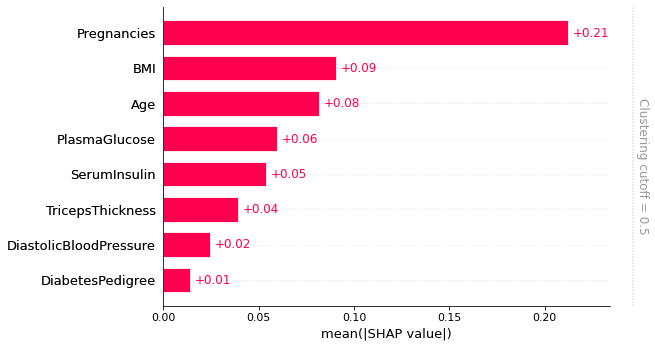

In [15]:
# explain test data
shap.plots.bar(shap_values, max_display=15)

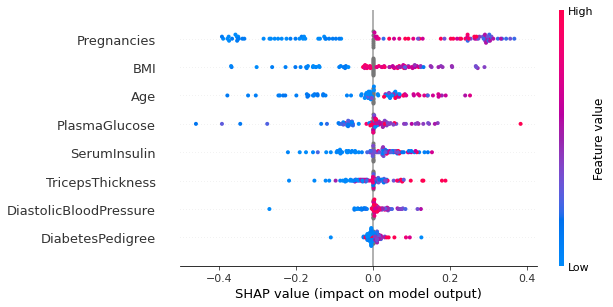

In [16]:
shap.plots.beeswarm(shap_values, max_display=15)

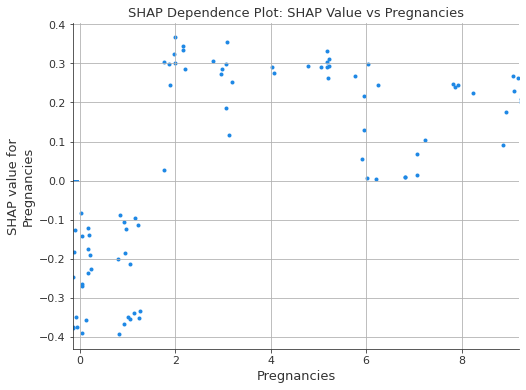

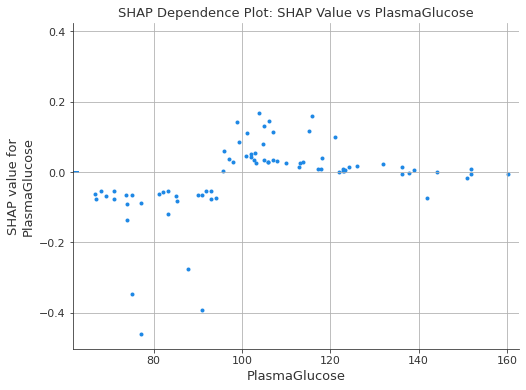

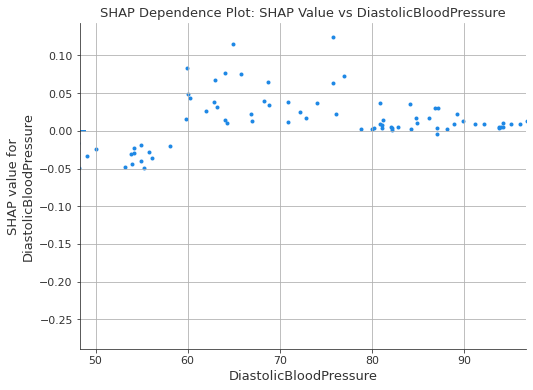

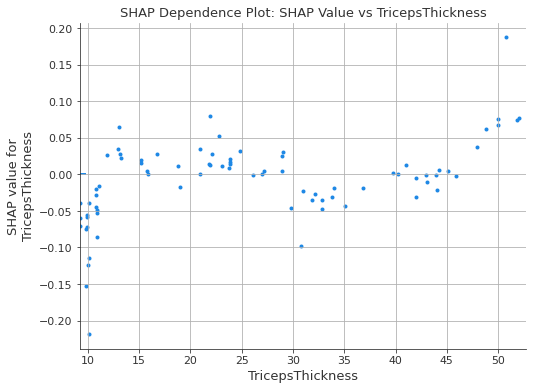

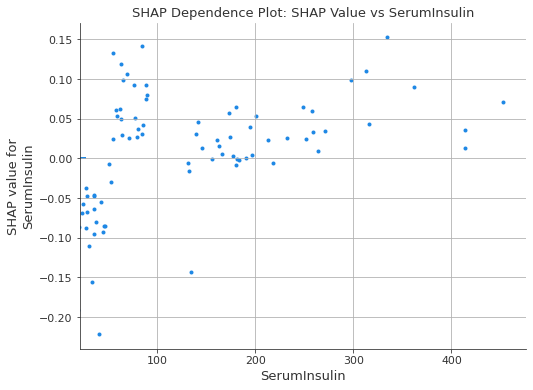

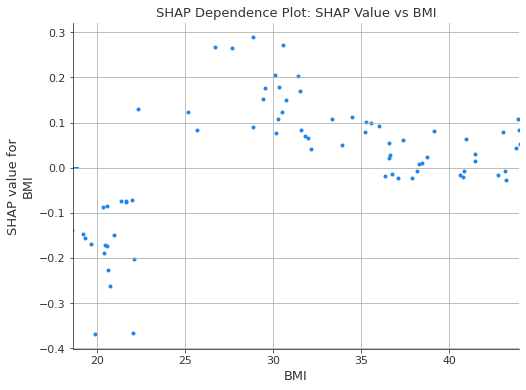

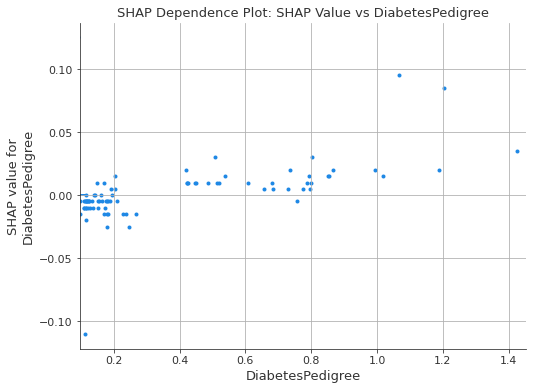

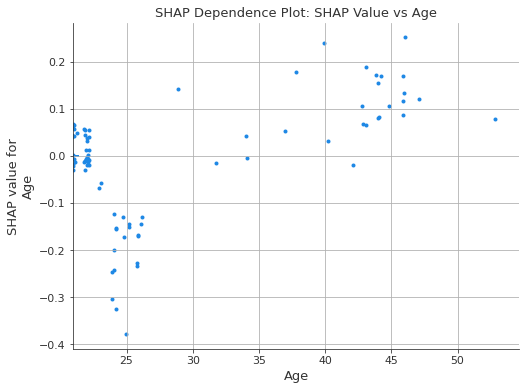

In [17]:
# show shap dependence plot for numeric features
for nf in X_test.columns:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(nf, 
                      shap_values = shap_values.values, 
                      features = X_test[0:100],
                      x_jitter = 0.5,
                      xmin="percentile(5.0)",
                      xmax="percentile(95.0)", 
                      interaction_index=None,
                      title = 'SHAP Dependence Plot: SHAP Value vs {}'.format(nf),
                      ax=ax,
                      show=False)
  ax.grid('on')

## Local Model Explanation

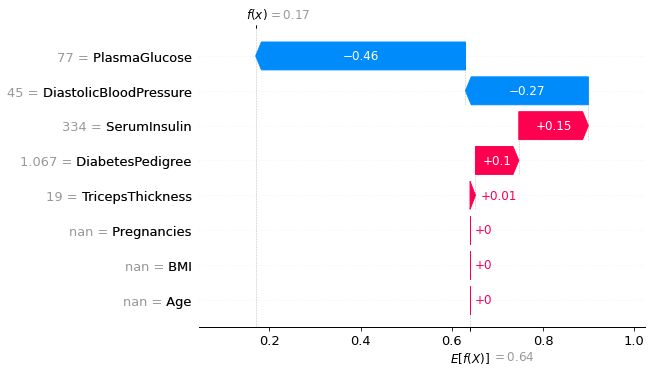

In [18]:
# explain selected prediction
ind=10
shap.plots.waterfall(shap_values[ind], max_display=20) 

## Explainer Dashboard

In [19]:
explainer = ClassifierExplainer(model, 
                                X_test[0:50], 
                                y_test[0:50], 
                                X_background=shap.sample(X_test[50:], 100))

Failed to to get the output feature names from your Pipeline! Probably the .get_feature_names_out() method is not yet implemented for one of your pipeline components. Check https://github.com/scikit-learn/scikit-learn/issues/21308 for progress...
Generating self.shap_explainer = shap.KernelExplainer(model, X_background, link='identity')


In [20]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/50 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.2:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

In [21]:
ExplainerDashboard.terminate(8050)

Trying to shut down dashboard on port 8050...
